### <시간대별 버스 이용량 분석>

In [1]:
#  - 기준월 및 기준일자별 버스 이용량분석 비교
#  - 기준일 및 시간대별 버스 이용량 분석 비교
#  - 기준시간 및 시간(분)별 버스 이용량 분석 비교

In [2]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import seaborn as sns
import platform

In [3]:
# seaborn 설정 리셋
sns.reset_defaults()

# 폰트설정
if platform.system() == 'Windows' :
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else :
    print('Check your OS System')
    
# 그래프에 마이너스 표시
matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:
# 데이터 불러오기 및 합치기
clear_df=pd.DataFrame()
for i in range(1,81,1):
    file_path ='./data/trfcard ({}).csv'.format(i) 
    df = pd.read_csv(file_path)
    clear_df = pd.concat([clear_df,df],ignore_index=True)
clear_df.head(1)

,on_date,off_date,route_name,descr,age_type,trans_yn,addfee_yn,start_bstop,start_gps_x,start_gps_y,end_bstop,end_gps_x,end_gps_y
0,20200102051049,20200102051844,131,양덕-송도-시청-양학-양덕,일반,N,N,양덕차고지,129.401693,36.077258,동부초등학교,129.380866,36.062209


In [5]:
# 영문컬럼명 -> 한글컬럼명 변환
col = pd.read_excel('./data/trfcard_columns.xlsx',header=2)
col = col[['컬럼명 (영문)','컬럼명 (한글)']]

col_list = col.to_dict('records')

new_dict = {}

for kv in col_list:
    new_dict[kv['컬럼명 (영문)']] = kv['컬럼명 (한글)']

clear_df = clear_df.rename(columns= new_dict)

In [6]:
# 데이터 전처리(결측치, 이상치)
clear_df.info()
clear_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842608 entries, 0 to 842607
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   승차시각         842608 non-null  int64  
 1   하차시각         842608 non-null  int64  
 2   노선명          842608 non-null  object 
 3   노선설명         842608 non-null  object 
 4   승객연령         842608 non-null  object 
 5   환승여부         842608 non-null  object 
 6   추가운임여부       842608 non-null  object 
 7   승차정류장        842608 non-null  object 
 8   승차정류장 GPS X  842608 non-null  float64
 9   승차정류장 GPS Y  842608 non-null  float64
 10  하차정류장        842608 non-null  object 
 11  하차정류장 GPS X  842608 non-null  float64
 12  하차정류장 GPS Y  842608 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 83.6+ MB


,승차시각,하차시각,승차정류장 GPS X,승차정류장 GPS Y,하차정류장 GPS X,하차정류장 GPS Y
count,8.426080e+05,8.426080e+05,842608.000000,842608.000000,842608.000000,842608.000000
mean,2.020017e+13,2.020017e+13,129.369875,36.033987,129.369699,36.030874
std,6.691819e+07,6.691830e+07,0.051007,0.044272,0.042348,0.034512
min,2.020010e+13,2.020010e+13,129.025585,35.804119,129.025585,35.804119
25%,2.020012e+13,2.020012e+13,129.350290,36.010240,129.353856,36.013250
50%,2.020013e+13,2.020013e+13,129.365486,36.031170,129.365281,36.033732
75%,2.020022e+13,2.020022e+13,129.384770,36.064088,129.371682,36.045735
max,2.020033e+13,2.020040e+13,129.579045,36.303479,129.579045,36.303479


In [7]:
# 데이터 전처리(중복치)
clear_df[clear_df.duplicated()]

,승차시각,하차시각,노선명,노선설명,승객연령,환승여부,추가운임여부,승차정류장,승차정류장 GPS X,승차정류장 GPS Y,하차정류장,하차정류장 GPS X,하차정류장 GPS Y


In [8]:
# 필요 컬럼 불러오기
df_final = clear_df[['승차시각','하차시각','노선명','승차정류장','하차정류장']]
df_final.head(1)

,승차시각,하차시각,노선명,승차정류장,하차정류장
0,20200102051049,20200102051844,131,양덕차고지,동부초등학교


In [9]:
# 시간 타입 변경
df_final['승차시각'] = df_final['승차시각'].astype(str)
df_final['하차시각'] = df_final['하차시각'].astype(str)

C:\Users\admin\AppData\Local\Temp\ipykernel_3480\1869089897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['승차시각'] = df_final['승차시각'].astype(str)
C:\Users\admin\AppData\Local\Temp\ipykernel_3480\1869089897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['하차시각'] = df_final['하차시각'].astype(str)


In [10]:
# 월,일,시간,분 각각 슬라이싱 후 컬럼생성
df_final['월'] = df_final['승차시각'].str[4:6]
df_final['일'] = df_final['승차시각'].str[6:8]
df_final['시'] = df_final['승차시각'].str[8:10]
df_final['분'] = df_final['승차시각'].str[10:12]
df_final

C:\Users\admin\AppData\Local\Temp\ipykernel_3480\3086384041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['월'] = df_final['승차시각'].str[4:6]
C:\Users\admin\AppData\Local\Temp\ipykernel_3480\3086384041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['일'] = df_final['승차시각'].str[6:8]
C:\Users\admin\AppData\Local\Temp\ipykernel_3480\3086384041.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,승차시각,하차시각,노선명,승차정류장,하차정류장,월,일,시,분
0,20200102051049,20200102051844,131,양덕차고지,동부초등학교,01,02,05,10
1,20200102051338,20200102054549,175,문덕사거리,새마을금고해도지점,01,02,05,13
2,20200102051549,20200102051930,160,문덕사거리,성우오토모티브,01,02,05,15
3,20200102051617,20200102055046,175,부영사랑3차,오거리,01,02,05,16
4,20200102051841,20200102052310,102,문덕온천,용덕사거리,01,02,05,18
...,...,...,...,...,...,...,...,...,...
842603,20200331231529,20200331232033,109,법원사거리,농협하나로클럽,03,31,23,15
842604,20200331231651,20200331232054,108,LG빌라입구,대잠중앙하이츠,03,31,23,16
842605,20200331233806,20200331234546,107,대동우방아파트,상대시장,03,31,23,38
842606,20200331234833,20200331235954,175,해병대서문,부영사랑3차,03,31,23,48


####  - 기준월 및 일별 버스 이용량 분석 비교

In [11]:
# 월,및 일별 pivot table 생성
pivot_df_m_d = df_final.pivot_table(index='일',values='노선명',columns='월',aggfunc='count').fillna(0)

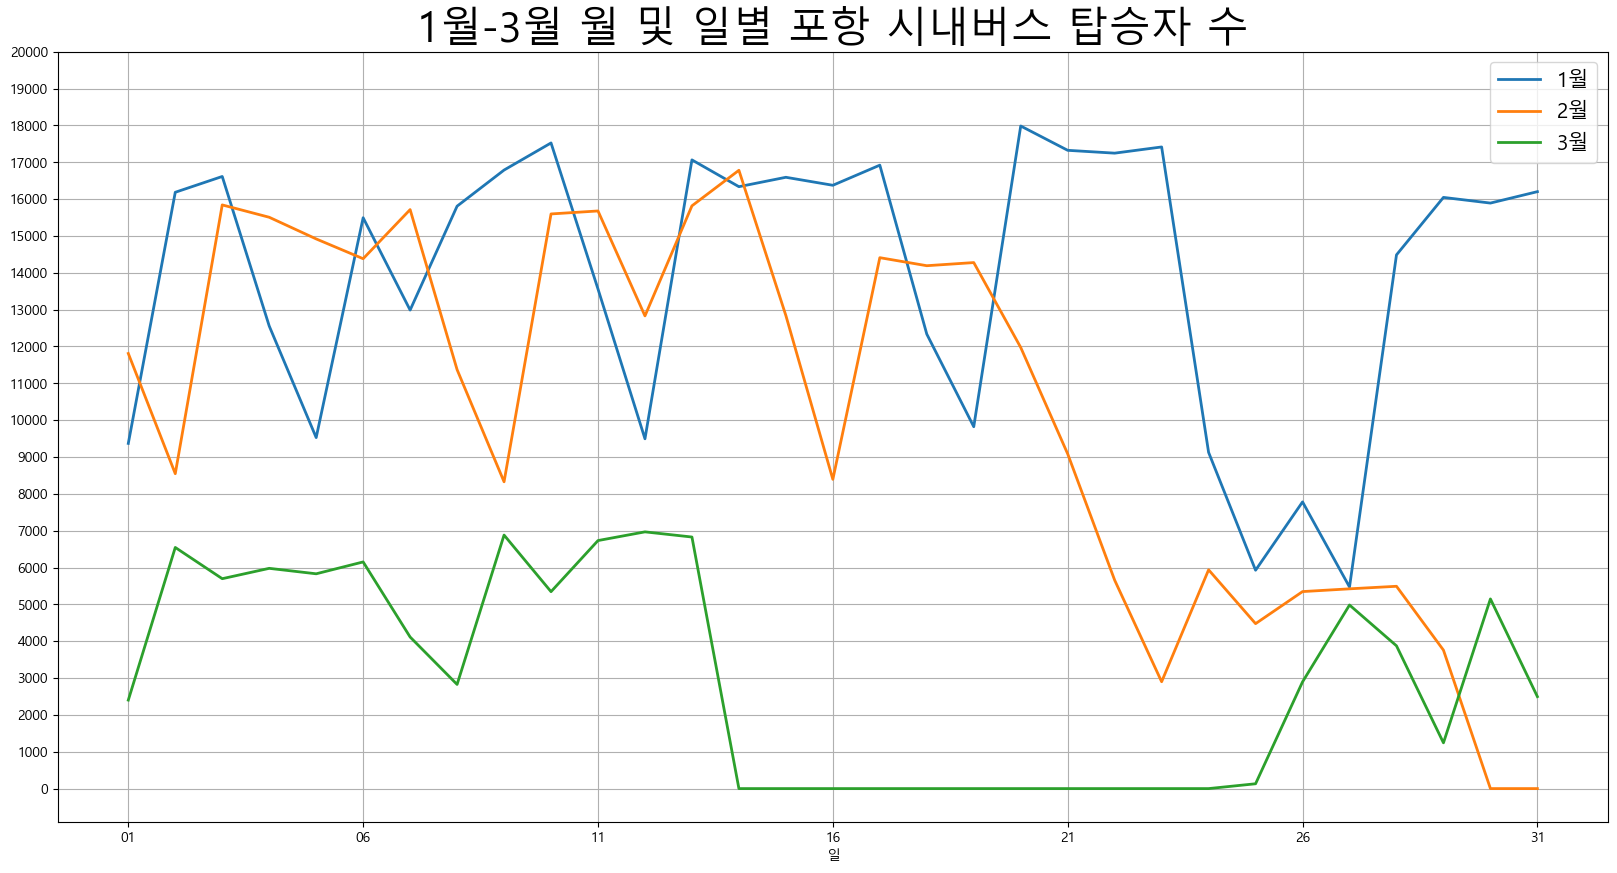

In [12]:
# 선 그래프
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['lines.linewidth'] = 2
pivot_df_m_d.plot()
plt.title('1월-3월 월 및 일별 포항 시내버스 탑승자 수', fontsize=30)
plt.yticks(range(0,21000,1000))
# 범례 설정
labels = ['1월','2월','3월']
plt.legend(labels=labels, loc='upper right',fontsize=15)
# 그래프 그리드 설정
plt.grid(True)
plt.show()

####  - 기준일 및 시간대별 버스 이용량 분석 비교

In [13]:
# 일,및 시간대별 pivot table 생성
pivot_df_d_h = df_final.pivot_table(index='일',values='노선명',columns='시',aggfunc='count').drop(columns='00')

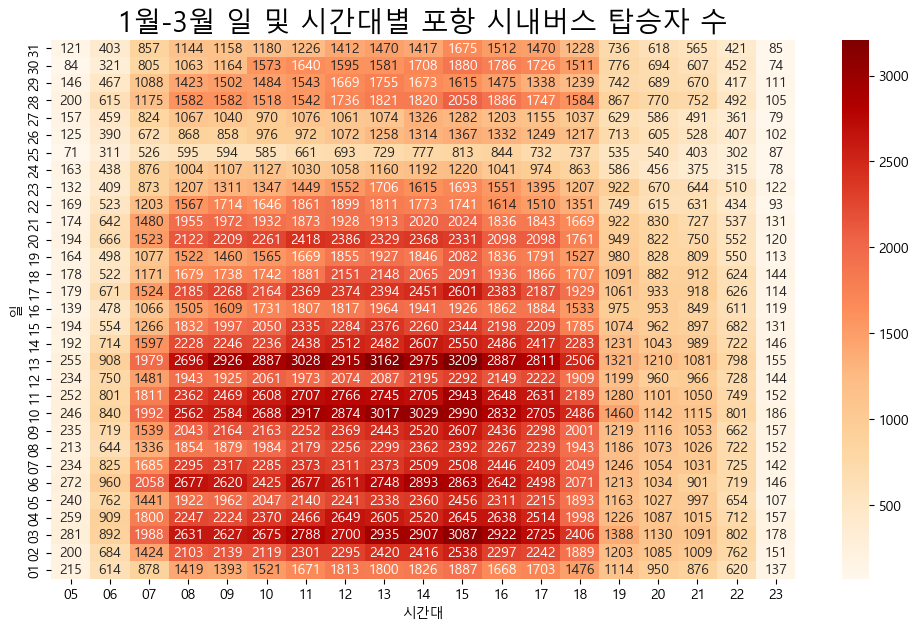

In [14]:
# 히트맵 그래프
plt.figure(figsize=(12,7))
sns.heatmap(pivot_df_d_h, annot=True, fmt='.0f',cmap='OrRd')
plt.gca().invert_yaxis()
plt.xlabel('시간대')
plt.ylabel('일')
plt.title('1월-3월 일 및 시간대별 포항 시내버스 탑승자 수',fontsize=20)

plt.show()

#### - 기준시간 및 시간(분)별 버스 이용량 분석 비교

In [15]:
# 분 컬럼 정수형 변환
df_final['분'] = df_final['분'].astype(int)

C:\Users\admin\AppData\Local\Temp\ipykernel_3480\4152950500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['분'] = df_final['분'].astype(int)


In [16]:
# 10분단위로 분대 정의
df_list = {}
df_h_m = pd.DataFrame()

for i in range(0,51,10):
    df_list[f'{i}분대'] = df_final[(df_final['분'] >= i+0) & (df_final['분'] <= i+9)].reset_index(drop =True)
    df_list[f'{i}분대']['분대'] = f'{i}-'f'{i+9}분'
    df_h_m = pd.concat([df_h_m,df_list[f'{i}분대']])

df_h_m

,승차시각,하차시각,노선명,승차정류장,하차정류장,월,일,시,분,분대
0,20200102060009,20200102062345,101,해군 항공역사관,죽도시장,01,02,06,0,0-9분
1,20200102060101,20200102063337,800,감포초등학교,오천농협세계지점,01,02,06,1,0-9분
2,20200102060113,20200102060708,131,양학온천프라자,죽도시장,01,02,06,1,0-9분
3,20200102060113,20200102060635,130,대림골든빌,동부초등학교,01,02,06,1,0-9분
4,20200102060142,20200102070658,107,준양참마을,흥해환승센터,01,02,06,1,0-9분
...,...,...,...,...,...,...,...,...,...,...
136477,20200331225258,20200331231719,102,환호해맞이그린빌,상대파출소,03,31,22,52,50-59분
136478,20200331225338,20200331230621,200,환호해맞이그린빌,홈플러스,03,31,22,53,50-59분
136479,20200331225754,20200331230712,200,두호동주민센터,죽도파출소,03,31,22,57,50-59분
136480,20200331225936,20200331230856,130,이동온천스포렉스,이동온천스포렉스,03,31,22,59,50-59분


In [17]:
# pivot table 생성 및 전처리
pivot_df_h_m = df_h_m.pivot_table(index='분대',values='노선명',columns='시',aggfunc='count')
pivot_df_h_m = pivot_df_h_m.drop(columns='00').fillna(0)

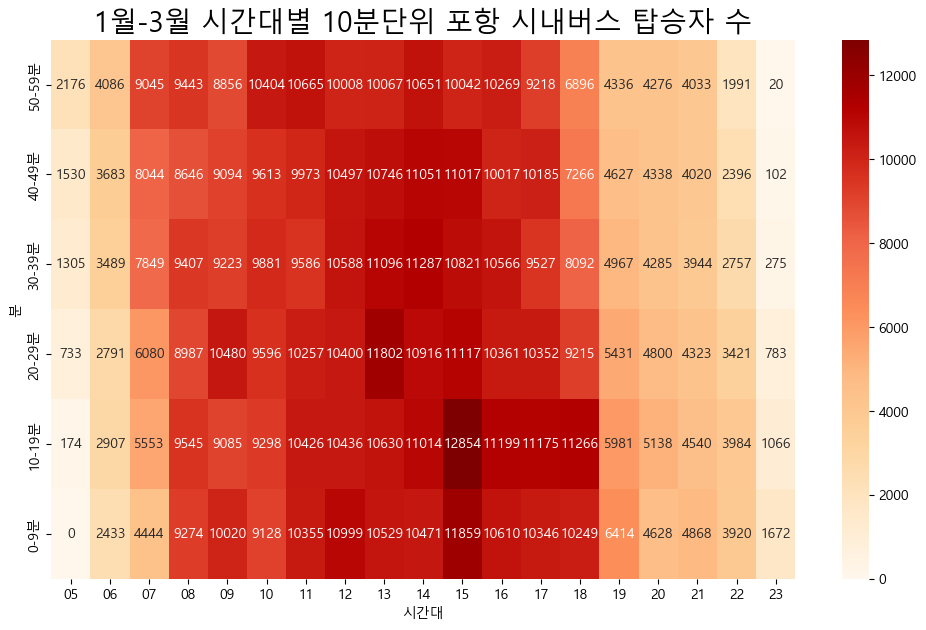

In [18]:
# 히트맵 그래프
plt.figure(figsize=(12,7))
sns.heatmap(pivot_df_h_m, annot=True, fmt='.0f',cmap='OrRd')
plt.gca().invert_yaxis()
plt.xlabel('시간대')
plt.ylabel('분')
plt.title('1월-3월 시간대별 10분단위 포항 시내버스 탑승자 수',fontsize=20)

plt.show()